In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [2]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [13]:
import sqlite3
import pandas as pd

db_path = 'real_estate_with_fflag.db'

# 연결
conn = sqlite3.connect(db_path)

df_origin = pd.read_sql("SELECT * FROM house", conn)

conn.close()

In [14]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7575 entries, 0 to 7574
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   house_id            7575 non-null   int64  
 1   title               7575 non-null   object 
 2   price               7575 non-null   object 
 3   address             7575 non-null   object 
 4   floor               5092 non-null   float64
 5   deposit_type        7575 non-null   object 
 6   management_fee      6280 non-null   float64
 7   available_from      7575 non-null   object 
 8   house_num           7575 non-null   int64  
 9   agent_comm          7557 non-null   float64
 10  agent_info          7575 non-null   object 
 11  rooms_count         7567 non-null   float64
 12  options             7575 non-null   object 
 13  posted_at           7510 non-null   object 
 14  gu                  7575 non-null   object 
 15  dong                7575 non-null   object 
 16  img_ur

In [15]:
df_origin.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score', '전세환산금액', '전세가율_이상'],
      dtype='object')

In [16]:
df = df_origin
df = df[df['deposit_type'] != '단기임대']

# 단기임대 데이터 분리
df_dangi = df_origin[df_origin['deposit_type']=='단기임대']

In [17]:
df['deposit_type'].unique()

array(['전세', '월세'], dtype=object)

In [18]:
df['building_type'].unique()

# ['공동주택', '단독주택', '제2종 근린생활시설', '업무시설', '제1종 근린생활시설', '건축물 용도 정보 없음',
#        '미등기건물', '숙박시설', '교육연구시설', '운동시설', '그 밖에 토지의 정착물',
#        '노유자(幼者: 노인 및 어린이)시설', '공장', '창고시설', '의료시설', '자동차 관련 시설']

array(['공동주택', '단독주택', '제2종 근린생활시설', '업무시설', '제1종 근린생활시설', '건축물 용도 정보 없음',
       '제1종근린생활시설', '미등기건물', '숙박시설', '그 밖에 토지의 정착물', '교육연구시설'],
      dtype=object)

In [19]:
import pandas as pd
import numpy as np
import re

def parse_area_column(df, col='area_size'):
    def parse_area(area_text):
        try:
            # '74.31㎡/49.92㎡(전용률67%)' 또는 '-㎡/38㎡' 처리
            matches = re.findall(r'([\d.]+)㎡', str(area_text))
            if len(matches) >= 1:
                return float(matches[-1])  # 전용면적만 추출
        except:
            pass
        return None

    df['전용면적'] = df[col].apply(parse_area)
    return df


### 2. 전처리 실행
df = parse_area_column(df)

In [20]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score', '전세환산금액', '전세가율_이상', '전용면적'],
      dtype='object')

In [21]:
# 평당가 구하기 : 전세가 / (전용면적 / 3.3)
df['평당가'] = df['전세환산금액'] / df['space']

df['평균_평당가'] = df.groupby(['gu', 'dong', 'deposit_type'])['평당가'].transform('mean')

# 가격오차율 (0.2 -> 0.4으로 완화 : 단지내(논문) -> 동 단위로 확장해서)
# 낮은 가격, 높은 가격 따로 매길지 (너무 낮은 가격이면 허위 매물일 가능성이 더 높을 것 같음)
df['가격오차율'] = abs(df['평당가'] - df['평균_평당가']) / df['평균_평당가']
df['가격_이상치'] = df['가격오차율'] > 0.4

In [23]:
df[['gu', 'dong', 'deposit_type', 'deposit', 'monthly_rent', '전용면적', '평당가', '평균_평당가', '가격오차율']].sample(5)

,gu,dong,deposit_type,deposit,monthly_rent,전용면적,평당가,평균_평당가,가격오차율
4790,강동구,암사동,월세,5000000,450000,26.00,7.819767e+05,7.587371e+06,0.896937
1884,강남구,신사동,월세,30000000,1750000,49.62,2.325581e+06,3.540641e+06,0.343175
6528,강서구,공항동,월세,20000000,300000,15.00,4.150000e+06,2.486727e+06,0.668860
4935,강동구,암사동,월세,10000000,560000,23.14,1.651827e+06,7.587371e+06,0.782293
4829,강동구,암사동,월세,20000000,800000,38.00,2.021142e+06,7.587371e+06,0.733618


In [24]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score', '전세환산금액', '전세가율_이상', '전용면적', '평당가', '평균_평당가', '가격오차율',
       '가격_이상치'],
      dtype='object')

In [26]:
### 3. 허위매물 조건 (논문 기반)
판별컬럼 = ['deposit', 'monthly_rent', '전용면적', 'rooms_count', 'bath_count', 'floor', 'built_date', 'building_type']

# 2) 정보 미기재
# 정보 없음 이라고 된 컬럼 null로 바꾸기 🚨
df['결측_컬럼수'] = df[판별컬럼].isna().sum(axis=1)
df['층정보_불명확'] = df['floor'].astype(str).str.contains('저|중|고|지하|반지하|옥탑|알수없음')
df['정보_미기재'] = (df['결측_컬럼수'] > 0) | (df['층정보_불명확'])

# 3) 중복 매물 이상치
df['매물키'] = (
    df['gu'] + "_" + df['dong'] + "_" +
    df['deposit_type'].astype(str) + '_' +
    df['price'].astype(str) + '_' +
    df['floor'].astype(str) + '_' +
    df['total_floor'].astype(str) + '_' +
    df['rooms_count'].astype(str) + '_' +
    df['bath_count'].astype(str) + '_' +
    df['agent_info'].astype(str)
)
df['중복개수'] = df.groupby('매물키')['매물키'].transform('count')
중복평균 = df['중복개수'].mean()
df['중복_이상치'] = df['중복개수'] > 중복평균

# 4) 건물용도가 주택이 아닌지
불량 = '제2종 근린생활시설|업무시설|제1종 근린생활시설|건축물 용도 정보 없음|' \
         '교육연구시설|운동시설|그 밖에 토지의 정착물|창고시설|' \
         '노유자|공장|자동차 관련 시설|의료시설'

df['건물용도불량'] = df['building_type'].str.contains(불량, na=False)

# 5) 전세가율 판단 (1 : 80%이상(위험))

In [28]:
# 방법1 : 셋 다 해당되면 허위 의심

# df['허위의심'] = df['가격_이상치'] & df['정보_미기재'] & df['중복_이상치']

# 방법2 : 각 특성별 가중치를 두기
# 가중치 : 가격_이상치 > 중복_이상치 > 정보_미기재
# 허위의심 True 개수 : 1889 1839

df['위험점수'] = (
    df['가격_이상치'].astype(int) * 2.5 +
    df['중복_이상치'].astype(int) * 1.5 +
    df['정보_미기재'].astype(int) * 2+ 
    df['건물용도불량'].astype(int) * 2 + 
    df['전세가율_이상'] * 2
)

df['위험매물'] = df['위험점수'] > 5

In [29]:
df[df['가격_이상치'] == True]['gu'].value_counts().sort_values(ascending=False)

gu
강남구    1735
강동구    1340
강서구     846
강북구     577
Name: count, dtype: int64

In [30]:
score_counts = df['위험점수'].value_counts().sort_index()
print(score_counts)

위험점수
0.0      672
1.5      103
2.0     1135
2.5     1232
3.5      328
4.0      613
4.5     1519
5.5      108
6.0      252
6.5     1092
7.5       31
8.0      227
8.5       66
10.0       6
Name: count, dtype: int64


In [35]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상', '전용면적', '방수', '욕실수', '해당층',
       '총층', '평당가', '평균_평당가', '가격오차율', '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재',
       '매물키', '중복개수', '중복_이상치', '건물용도불량', '위험점수', '위험매물'],
      dtype='object')

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# 1. 특성 선택 및 스케일링
features = ['deposit', 'monthly_rent', '전용면적', 'rooms_count', 'bath_count', 'floor']
X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 2. pseudo-label(허위의심:1, 정상:0)
# '허위의심' 라벨 변경 (True -> 1, False -> 0)
def assign_pseudo(label):
    return 1 if label else 0  # 더 이상 -1 사용하지 않음

df['pseudo'] = df['위험매물'].apply(assign_pseudo)

# 3. self-training 학습용 데이터 (이제는 0과 1 둘 다 포함)
X_self = X_scaled.copy()
y_self = df['pseudo']

# 4. 모델 학습
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_self, y_self)

# 5. 확률 예측 및 최종 의심 플래그
df['최종위험점수'] = np.round(clf.predict_proba(X_scaled)[:, 1], 2)*100
#df['최종허위의심'] = df['최종허위점수'] > 70

In [44]:
df['safety_grade'] = pd.cut(df['최종위험점수'],
                      bins=[0, 20, 40, 60, 80, 100],
                      labels=['🟢 매우 안전','🔵 안전','🟡 보통','🟠 주의 ','🔴 위험'],
                      right=False, include_lowest=True)

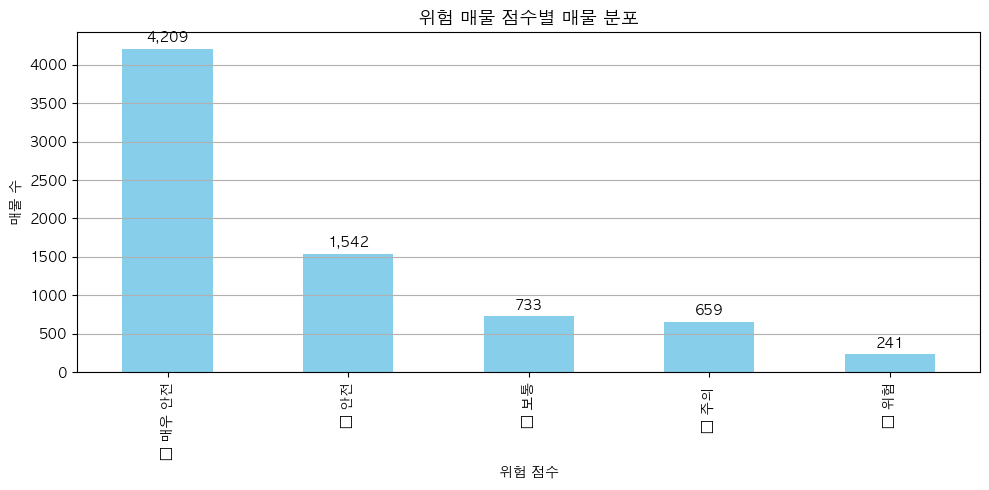

In [45]:
import matplotlib.pyplot as plt

score_counts = df['safety_grade'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
score_counts.plot(kind='bar', color='skyblue')

# 막대 위 숫자 표시
for i, count in enumerate(score_counts):
    plt.text(i, count + (score_counts.max() * 0.01), f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.title('위험 매물 점수별 매물 분포', fontsize=13)
plt.xlabel('위험 점수')
plt.ylabel('매물 수')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [46]:
# 위험 등급의 매물들 확인
dangerous_houses = df[df['safety_grade'] == '🔴 위험']

# 위험 등급의 매물들에 대한 상세 정보 출력
print("위험 등급의 매물 개수:", len(dangerous_houses))
print("\n위험 등급의 매물들 정보:")
print(dangerous_houses[['dong', 'deposit', 'monthly_rent', '평당가', '평균_평당가', '가격오차율']].sample(10))

# 위험 등급의 주요 특징 분석
print("\n평균 가격오차율:", dangerous_houses['가격오차율'].mean())
print("평균 평당가:", dangerous_houses['평당가'].mean())
print("평균 평균_평당가:", dangerous_houses['평균_평당가'].mean())

위험 등급의 매물 개수: 241

위험 등급의 매물들 정보:
     dong     deposit  monthly_rent           평당가        평균_평당가     가격오차율
3004  청담동    37000000       3820000  3.404319e+06  1.406860e+07  0.758020
7462  마곡동   156000000        100000  2.232143e+07  9.545435e+06  1.338440
7442  마곡동    10000000        780000  1.707143e+06  9.545435e+06  0.821156
2619  자곡동    10000000        700000  1.494186e+06  7.432402e+06  0.798963
1576  수서동    10000000        700000  9.961240e+05  4.382601e+06  0.772709
522   논현동    35000000       3500000  3.197674e+06  7.500342e+06  0.573663
484   논현동  1700000000             0  2.428571e+08  5.626703e+07  3.316153
261   개포동    10000000        750000  1.209302e+06  2.004671e+07  0.939676
1570  수서동    10000000        750000  9.302326e+05  4.382601e+06  0.787744
1436  삼성동    10000000       1100000  2.178295e+06  6.758990e+06  0.677719

평균 가격오차율: 1.0659675505401398
평균 평당가: 12564644.931086516
평균 평균_평당가: 9353809.866139568


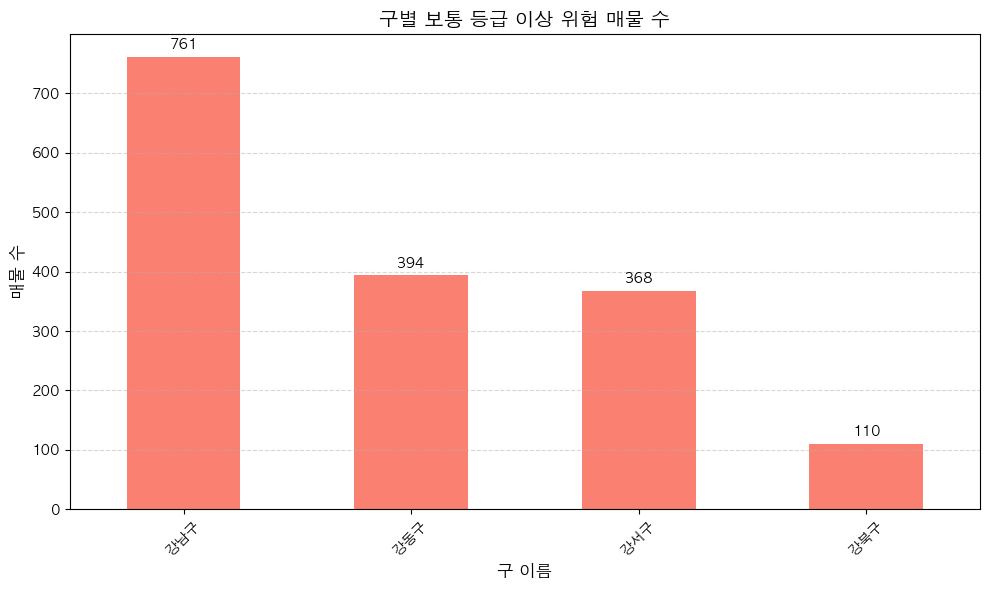

In [39]:
# 1. 40점 이상 매물 필터링
df_high_risk = df[df['최종위험점수'] >= 40]

# 2. 구별 개수 집계
gu_risk_counts = df_high_risk['gu'].value_counts().sort_values(ascending=False)

# 3. 시각화
plt.figure(figsize=(10, 6))
gu_risk_counts.plot(kind='bar', color='salmon')

# 4. 수치 라벨 추가
for i, count in enumerate(gu_risk_counts):
    plt.text(i, count + gu_risk_counts.max()*0.01, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.title('구별 보통 등급 이상 위험 매물 수', fontsize=14)
plt.xlabel('구 이름', fontsize=12)
plt.ylabel('매물 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [40]:
# 구별 전체 매물 수
total_per_gu = df['gu'].value_counts()

# 구별 위험 매물 수
risk_per_gu = df[df['최종위험점수'] >= 40]['gu'].value_counts()

# 비율 계산
risk_ratio = (risk_per_gu / total_per_gu * 100).sort_values(ascending=False)

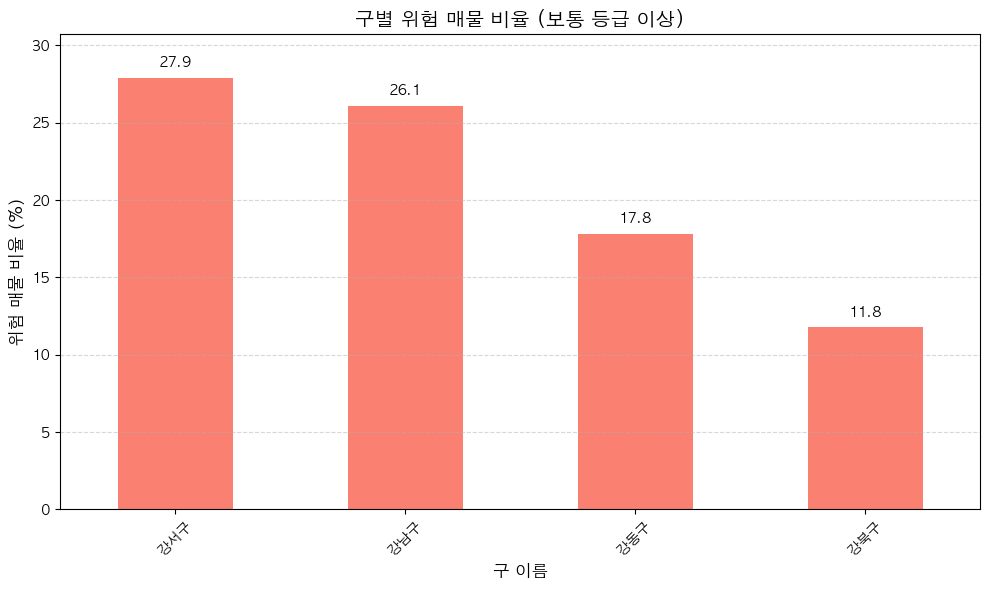

In [41]:
plt.figure(figsize=(10, 6))
risk_ratio.plot(kind='bar', color='salmon')

# 비율 수치 표시
for i, ratio in enumerate(risk_ratio):
    plt.text(i, ratio + 0.5, f'{ratio:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('구별 위험 매물 비율 (보통 등급 이상)', fontsize=14)
plt.xlabel('구 이름', fontsize=12)
plt.ylabel('위험 매물 비율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, risk_ratio.max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:
df_origin.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score', '전세환산금액', '전세가율_이상'],
      dtype='object')

In [48]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score', '전세환산금액', '전세가율_이상', '전용면적', '평당가', '평균_평당가', '가격오차율',
       '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재', '매물키', '중복개수', '중복_이상치',
       '건물용도불량', '위험점수', '위험매물', 'pseudo', '최종위험점수', '안전등급'],
      dtype='object')

In [49]:
df_final = df.drop(['전세환산금액', '전세가율_이상', '전용면적', '평당가', '평균_평당가', '가격오차율',
       '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재', '매물키', '중복개수', '중복_이상치',
       '건물용도불량', '위험점수', '위험매물', 'pseudo', '최종위험점수', '안전등급'], axis=1)

In [56]:
df_final.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       'safety_grade'],
      dtype='object')

In [51]:
# 단기임대 데이터 병합해서 다시 삽입

df_all = pd.concat([df_final, df_dangi], ignore_index=True)

In [53]:
df_all = df_all.drop(['전세환산금액', '전세가율_이상'], axis=1)

In [55]:
df_all.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'available_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'safety_grade',
       'deposit', 'monthly_rent', 'space', 'bath_count', 'total_floor',
       'latitude', 'longitude', 'final_embedding', 'gpt_description',
       'safety_score'],
      dtype='object')

In [56]:
from sqlalchemy import create_engine
from config import DB_CONFIG

engine = create_engine(
    f"mysql+mysqlconnector://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

# df_all을 grade_house 테이블로 저장 (테이블 있으면 덮어씀)
df_all.to_sql('grade_house', engine, if_exists='replace', index=False)

7575

In [66]:
# import sqlite3

# # 데이터베이스 연결
# conn = sqlite3.connect('real_estate_with_grade.db')

# # 데이터프레임을 SQLite 테이블로 저장
# df_all.to_sql('house', conn, if_exists='replace', index=False)

# # 연결 종료
# conn.close()